<a href="https://colab.research.google.com/github/xonew/DSCI-100-002-Group-26/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Run these first!

In [17]:
#install.packages("tidymodels")
#install.packages("kknn")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [23]:
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
set.seed(900)

In [24]:
set.seed(900)

#reads the raw data sets and converts them into tibbles with no column names
cleveland_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.cleveland.data', col_names = FALSE) |> as_tibble()
hungarian_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.hungarian.data', col_names = FALSE) |> as_tibble()

#combines the two data sets into one
heart_data <- rbind(cleveland_data, hungarian_data)

#assigns names to the columns based on information from the website
colnames(heart_data) <- c('age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'max_hr',
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')

#converts all categorical attributes into factors
heart_data <- mutate(heart_data, sex = as.factor(sex), chest_pain = as.factor(chest_pain),
    num = replace(num, num > 0, 1), num = as.factor(num), fbs = as.factor(fbs), restecg = as.factor(restecg),
    exang = as.factor(exang), thal = as.factor(thal), slope = as.factor(slope), ca = as.factor(ca)) |>

#removes missing values from the cholesterol and resting blood pressure columns
filter(chol != '?', trestbps != '?') |>

#converts all necessary numerical attributes into doubles
mutate(chol = as.double(chol), trestbps = as.double(trestbps))

#splits data into testing and training sets
heart_split <- heart_data |>
  select(num, age, trestbps, chol) |>
  initial_split( prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,age,trestbps,chol
<fct>,<dbl>,<dbl>,<dbl>
0,63,145,233
0,57,120,354
0,57,140,192
0,44,120,263
0,52,172,199
0,57,150,168
0,49,130,266
0,64,110,211
0,58,120,340


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6458333
kap,binary,0.2731591


          Truth
Prediction  0  1
         0 58 25
         1 26 35

.pred_class
<fct>
0


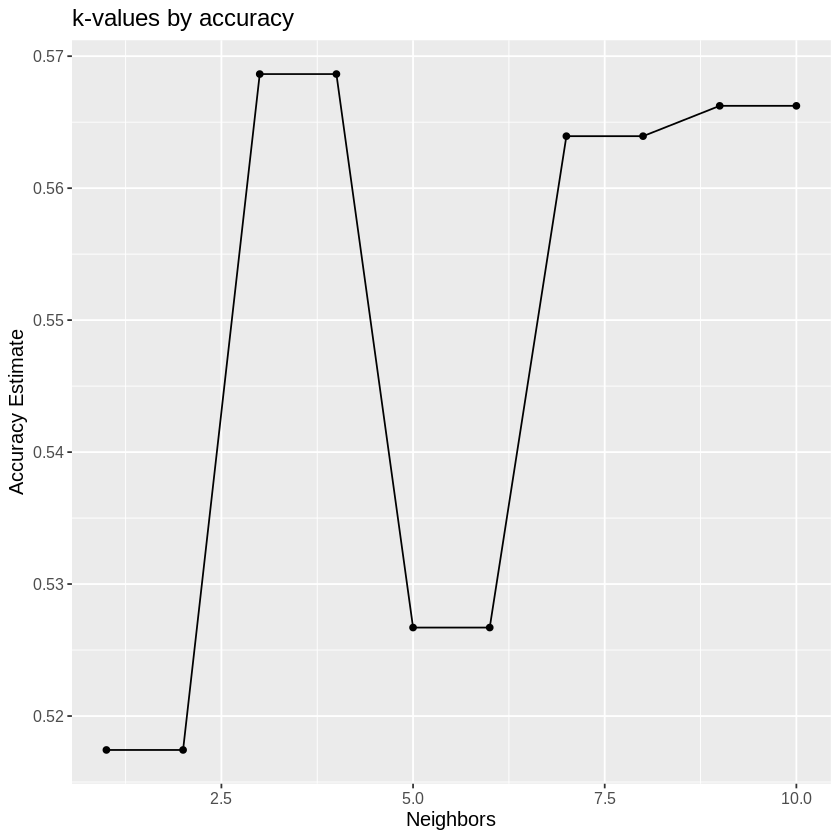

In [33]:
set.seed(900)
# creating the recipe for everything
heart_recipe <- recipe(num ~ ., data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

data_vfold <- vfold_cv(heart_train, v = 5, strata = num)

# creating the spec for the vfold
knn_spec_v <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


#creating the workflow for the vfold

accuracies <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_v) |>
  tune_grid(resamples = data_vfold, grid = ks) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

#plot of accuracy by k value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "k-values by accuracy") +
  theme(text = element_text(size = 12))

accuracy_vs_k

k_min <- accuracies |>
    arrange(desc(mean)) |>
    slice(1)|>
    pull(neighbors)

# creating the spec for the final model
knn_spec_f <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating the workflow for the final model
knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_f) |>
  fit(data = heart_train)

#determining the accuracy using our testing set
predictions <- knn_fit |>
           predict(heart_test) |>
bind_cols(heart_test |> select(num))

#metrics
metrics <- predictions |>
           metrics(truth = num, estimate = .pred_class)

#confidence matrix
conf_mat <- predictions |>
    conf_mat(truth = num, estimate = .pred_class)
metrics
conf_mat
avg_person <- tibble(num = 0, age = 30, trestbps = 120, chol = 170)

#predicting whether an average person has heart disease
predict(knn_fit, avg_person)